In [7]:
pip install flask fastapi tensorflow pillow PIL

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [15]:
pip install tensorflow keras

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
    --------------------------------------- 7.1/390.3 MB 39.6 MB/s eta 0:00:10
   - -------------------------------------- 13.9/390.3 MB 34.9 MB/s eta 0:00:11
   -- ------------------------------------- 23.6/390.3 MB 38.3 MB/s eta 0:00:10
   --- ------------------------------------ 32.8/390.3 MB 39.3 MB/s eta 0:00:10
   ---- ----------------------------------- 43.8/390.3 MB 42.2 MB/s eta 0:00:09
   ----- ---------------------------------- 54.0/390.3 MB 43.5 MB/s eta 0:00:08
   ------ --------------------------------- 64.0/390.3 MB 43.4 MB/s eta 0:00:08
   ------- -------------------------------- 74.7/390.3 MB 44.1 MB/s eta 0:00:08
   -------- ------------------------------- 85.7/390.3 MB 44.8 MB/s eta 0:00:07
   --------- ------------------------------ 95.9/390.3 MB 45.4 MB/s eta 0:00:07
   ---------- ---------------------------- 107.0/390.

In [17]:
# rodents_path = kagglehub.dataset_download('ojoolasehindeitunu/rodents')
rodents_path = r"C:\Users\dorot\OneDrive\Desktop\rodent"

In [19]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from PIL import Image

import seaborn as sns
import os
# import cv2
import tensorflow as tf
import keras
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import regularizers, callbacks
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import  Concatenate,LeakyReLU,BatchNormalization,Activation,ReLU,Conv2DTranspose
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

import warnings
warnings.filterwarnings('ignore')

In [21]:
model_path = r"C:\Users\dorot\Downloads\EfficientNet_B01.h5"

In [23]:
# image_data = ojoolasehindeitunu_rodents_path
image_data = rodents_path
data_files = [i for i in glob.glob(image_data + '//*//*')]
np.random.shuffle(data_files)
Rodent_labels = [os.path.dirname(i).split('/')[-1] for i in data_files]
Rodent_data = zip(data_files, Rodent_labels)
Rodent_df = pd.DataFrame(Rodent_data, columns=["Image", 'Label'])
Rodent_df.head()

,Image,Label
0,C:\Users\dorot\OneDrive\Desktop\rodent\Shrew\i...,C:\Users\dorot\OneDrive\Desktop\rodent\Shrew
1,C:\Users\dorot\OneDrive\Desktop\rodent\Mice\im...,C:\Users\dorot\OneDrive\Desktop\rodent\Mice
2,C:\Users\dorot\OneDrive\Desktop\rodent\Rats\im...,C:\Users\dorot\OneDrive\Desktop\rodent\Rats
3,C:\Users\dorot\OneDrive\Desktop\rodent\Mice\im...,C:\Users\dorot\OneDrive\Desktop\rodent\Mice
4,C:\Users\dorot\OneDrive\Desktop\rodent\Rats\im...,C:\Users\dorot\OneDrive\Desktop\rodent\Rats


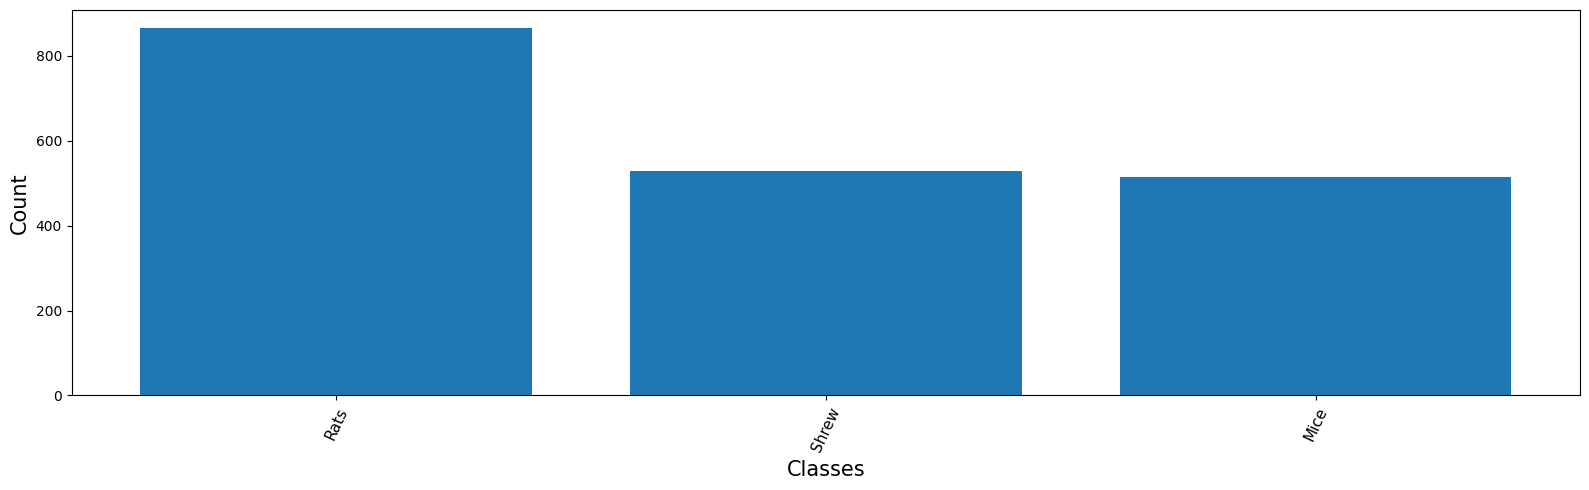

In [5]:
# value_counts() counts the occurrences of each unique value in the 'classes' column.
classes_count = Rodent_df["Label"].value_counts().reset_index()

# Rename the columns of the resulting DataFrame to "classes" and "count".
classes_count.columns = ["Label", "count"]

# Set the figure size for the plot to make sure it's wide enough to display all the class labels clearly.
plt.figure(figsize=(16, 5))

# Create a bar plot where the x-axis represents the class labels and the y-axis represents the count of images in each class.
plt.bar(classes_count["Label"], classes_count["count"])

# Set the label for the x-axis with a font size of 15 for better readability.
plt.xlabel("Classes", fontsize=15)

# Set the label for the y-axis, which represents the count of images, with a font size of 15.
plt.ylabel("Count", fontsize=15)

# Rotate the x-axis labels (class names) by 65 degrees to avoid overlap and make them easier to read.
# Also, set the font size of the x-axis labels to 11 for clarity.
plt.xticks(rotation=65, fontsize=11)

# Adjust the layout of the plot to ensure everything fits nicely within the figure, avoiding label cutoff.
plt.tight_layout()

# Display the bar plot.
plt.show()

In [25]:
batch_size = 8
target_size = (224, 224)
validation_split = 0.2
test_split = 0.1

all_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    image_size=target_size,
    batch_size=batch_size
)



Found 1909 files belonging to 3 classes.


In [26]:
dataset_size = tf.data.experimental.cardinality(all_data).numpy()

train_size = int(dataset_size * (1 - validation_split - test_split))
validation_size = int(dataset_size * validation_split)
test_size = dataset_size - train_size - validation_size

train = all_data.take(train_size)
remaining_data = all_data.skip(train_size)

validation = remaining_data.take(validation_size)
test = remaining_data.skip(validation_size)

(8, 224, 224, 3)
(8,)


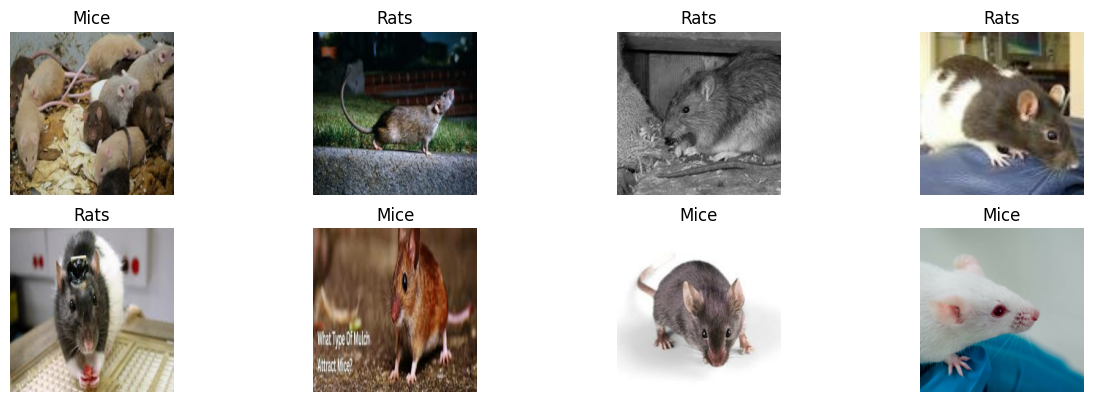

In [8]:
class_names = all_data.class_names

plt.figure(figsize=(15, 20))
num_images_per_class = 4
count = {class_name : 0 for class_name in class_names}

for images, labels in train.take(1):
    print(images.shape)
    print(labels.shape)
    for i in range(len(labels)):
        label = class_names[labels[i]]

        if count[label] < num_images_per_class:
            ax = plt.subplot(8, 4, sum(count.values()) + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(label)
            plt.axis('off')
            count[label] += 1

        if sum(count.values()) >= num_images_per_class * len(class_names):
            break

In [29]:
# Split the test data into training, validation and test sets
train_df, valid = train_test_split(Rodent_df, train_size=0.8, shuffle=True, random_state=123)

valid_df, test_df = train_test_split(valid, train_size=0.5, shuffle=True, random_state=123)

In [31]:
train_df.shape, valid_df.shape, test_df.shape

((1527, 2), (191, 2), (191, 2))

**Preprocessing**

In [33]:
# Create ImageDataGenerators for training, validation, and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='Image', y_col='Label', target_size=target_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='Image', y_col='Label', target_size=target_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='Image', y_col='Label', target_size=target_size,
                                      class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 1527 validated image filenames belonging to 3 classes.
Found 191 validated image filenames belonging to 3 classes.
Found 191 validated image filenames belonging to 3 classes.


In [35]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator

#### Feature scaling

In [38]:
# Rescaling layer
Norm_layer = tf.keras.layers.Rescaling(1 / 255)

# def preprocess_dataframe(dataset):

#     filepaths, labels = [], []
#     for element in dataset.as_numpy_iterator():
#         filepaths.append(element['Image'])
#         labels.append(element['Label'])
#     return filepaths, labels

# Convert DataFrame to a tf.data.Dataset
def preprocess_dataframe(df):
    filepaths = df['Image'].values
    labels = df['Label'].values
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    return dataset


# Load images and apply normalization
def preprocess_function(Image, Label):
    # Load and decode image
    image = tf.io.read_file(Image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to target size
    image = Norm_layer(image)  # Apply normalization
    return image, Label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label


# Prepare datasets
train_df = preprocess_dataframe(train_df)
train_df = train_df.map(preprocess_function)
train_df = train_df.map(augment_image)

valid_df = preprocess_dataframe(valid_df)
valid_df = valid_df.map(preprocess_function)
valid_df = valid_df.map(augment_image)

test_df = preprocess_dataframe(test_df)
test_df = test_df.map(preprocess_function)
test_df = test_df.map(augment_image)


In [40]:
# Batch and prefetch for performance
train_df = train_df.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_df = valid_df.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify the dataset
for image, label in train_df.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

Image shape: (8, 224, 224, 3)
Label: tf.Tensor(
[b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Mice'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Shrew'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Mice'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Mice'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Shrew'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Shrew'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Rats'
 b'C:\\Users\\dorot\\OneDrive\\Desktop\\rodent\\Rats'], shape=(8,), dtype=string)


In [15]:
iterator = train_df.as_numpy_iterator()

### MODEL BUILDING

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

#### CNN

In [ ]:
Cnn_model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= (224, 224, 3)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(3, activation = "softmax")
])

Cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

Cnn_model.summary()

In [ ]:
history = Cnn_model.fit(train_gen, epochs= 25, verbose= 1,
                        validation_data= valid_gen, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Predictions

In [ ]:
preds = Cnn_model.predict(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1)

### EVALUATION

In [ ]:
train_score = Cnn_model.evaluate(train_gen, verbose= 1)
valid_score = Cnn_model.evaluate(valid_gen, verbose= 1)
test_score = Cnn_model.evaluate(test_gen, verbose= 1)
# auc_score = roc_auc_score(test_gen.classes, y_pred, multi_class='ovr')  # or 'ovo'

# print(f"ROC AUC Score: {auc_score:.4f}")
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, y_pred))

#### Confusion Matrix

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Purples)
plt.title('Convolutional Neural Network Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


### MobileNet

In [ ]:
from keras.applications.mobilenet import MobileNet

# Instantiating imported model

Mobilenet = MobileNet(input_shape = (224, 224, 3),
                      weights='/kaggle/input/mobilenet/tensorflow2/default/1/mobilenet_1_0_224_tf_no_top.h5',
                      include_top = False)

In [ ]:
for i in Mobilenet.layers:
    i.trainable = False
# Adding Flattening and final dense layer to model

Output = Flatten()(Mobilenet.output)
Out = Dense(3, activation = 'softmax')(Output)

model = Model(Mobilenet.input, Out)
# Modified model info

model.summary()
Model: "model"

In [ ]:
# Compiling model

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [ ]:
# Fitting model

MobileNet_hist = model.fit(train_gen, epochs= 15, verbose= 1, validation_data = valid_gen,
                           shuffle= False)

In [ ]:
# Define needed variables
tr_acc = MobileNet_hist.history['accuracy']
tr_loss = MobileNet_hist.history['loss']
val_acc = MobileNet_hist.history['val_accuracy']
val_loss = MobileNet_hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
Mobile_preds = model.predict(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
M_pred = np.argmax(Mobile_preds, axis=1)

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, M_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, M_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix for MobileNetV1')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


**MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 without the top layer
Mobilenet_II = MobileNetV2(
    weights='/kaggle/input/mobilenet-v2/tensorflow2/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5',         # Pre-trained weights
    include_top=False,          # Exclude the top (fully connected) layer
    input_shape=(224, 224, 3)   # Input shape for your dataset
)

# Freeze the layers of the base model
for layer in Mobilenet_II.layers:
    layer.trainable = False

# Add custom layers to the pre-trained model
Output = Flatten()(Mobilenet_II.output)          # Flatten the feature maps
Output = Dropout(0.5)(Output)                    # Add dropout to reduce overfitting
Output = Dense(128, activation='relu')(Output)  # Add a dense layer
Output = Dropout(0.3)(Output)                    # Add another dropout
Out = Dense(3, activation='softmax')(Output)    # Final output layer

# Create the final model
model_II = Model(inputs=Mobilenet_II.input, outputs=Out)

# Compile the model
model_II.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_II.summary()


In [ ]:
# Compiling model

model_II.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [ ]:
# Fitting model

MobileNet_hist_II = model_II.fit(train_gen, epochs= 15, verbose= 1,
                                 validation_data = valid_gen, shuffle= False)


In [ ]:
# Define needed variables
tr_acc = MobileNet_hist_II.history['accuracy']
tr_loss = MobileNet_hist_II.history['loss']
val_acc = MobileNet_hist_II.history['val_accuracy']
val_loss = MobileNet_hist_II.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
Mobile_preds = model_II.predict(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
M_pred = np.argmax(Mobile_preds, axis=1)

In [ ]:
train_score = model_II.evaluate(train_gen, verbose= 1)
valid_score = model_II.evaluate(valid_gen, verbose= 1)
test_score = model_II.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, M_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, M_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix for MobileNetV2')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


### ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224,224,3),include_top=False,
                    weights = "/kaggle/input/resnet50/tensorflow2/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

for layer in base_model.layers:
    layer.trainable=True


x=base_model.output
x=Flatten()(x)
pred=Dense(3,activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=pred)

In [ ]:
model2.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = True


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(3, activation="softmax")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy" , metrics  = ["accuracy"])

# Fitting model

History = model.fit(train_gen, epochs= 18, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = History.history['accuracy']
tr_loss = History.history['loss']
val_acc = History.history['val_accuracy']
val_loss = History.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
Res_preds = model.predict(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
R_pred = np.argmax(Res_preds, axis=1)

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, R_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, R_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix for ResNet50')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


### EfficientNet

In [42]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False,
                            weights='imagenet',
                            input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable=True

# Add custom layers on top of EfficientNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
y=Dense(3,activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=y)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model2.summary()

In [44]:
for layer in base_model.layers:
    layer.trainable = True


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(3, activation="softmax")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [46]:
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy" , metrics  = ["accuracy"])

# Fitting model

History = model.fit(train_gen, epochs= 14, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.6157 - loss: 0.8638 - val_accuracy: 0.6963 - val_loss: 0.9827
Epoch 2/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 166s 869ms/step - accuracy: 0.7760 - loss: 0.5557 - val_accuracy: 0.7068 - val_loss: 0.8917
Epoch 3/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 162s 847ms/step - accuracy: 0.8266 - loss: 0.4395 - val_accuracy: 0.7382 - val_loss: 0.8344
Epoch 4/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 160s 835ms/step - accuracy: 0.8542 - loss: 0.3385 - val_accuracy: 0.6806 - val_loss: 0.9967
Epoch 5/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 160s 839ms/step - accuracy: 0.8779 - loss: 0.2970 - val_accuracy: 0.7487 - val_loss: 0.7977
Epoch 6/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 160s 837ms/step - accuracy: 0.9148 - loss: 0.2303 - val_accuracy: 0.7225 - val_loss: 1.0269
Epoch 7/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 160s 836ms/step - accuracy: 0.8919 - loss: 0.2933 - val_accuracy: 0.7435 - val_loss: 1.0029
Epoch 8/14
191/191 ━━━━━━━━━━━━━━━━━━━━ 161s 840ms/step - accuracy: 0.9200 - lo

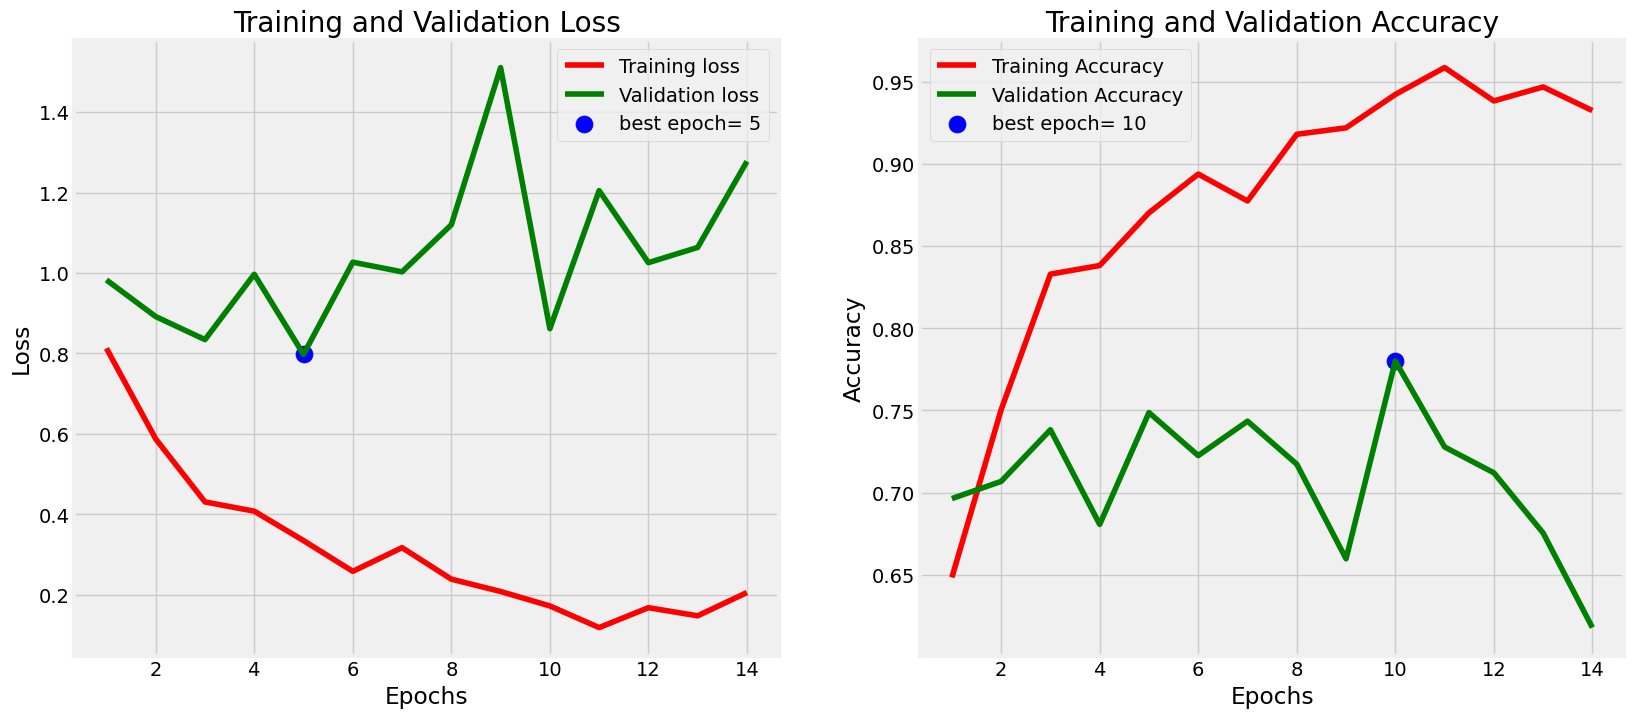

In [47]:
# Define needed variables
tr_acc = History.history['accuracy']
tr_loss = History.history['loss']
val_acc = History.history['val_accuracy']
val_loss = History.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [48]:
Eff_preds = model.predict(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
Eff_pred = np.argmax(Eff_preds, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step


In [49]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, Eff_pred))

191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - accuracy: 0.8631 - loss: 0.3357
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5824 - loss: 1.4423
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.6740 - loss: 1.0416
Train Loss:  0.36091458797454834
Train Accuracy:  0.848068118095398
--------------------
Validation Loss:  1.2774814367294312
Validation Accuracy:  0.6178010702133179
--------------------
Test Loss:  1.177682638168335
Test Accuracy:  0.6649214625358582
              precision    recall  f1-score   support

           0       0.60      0.57      0.58        49
           1       0.86      0.52      0.65        85
           2       0.59      0.96      0.73        57

    accuracy                           0.66       191
   macro avg       0.68      0.68      0.65       191
weighted avg       0.71      0.66      0.66       191



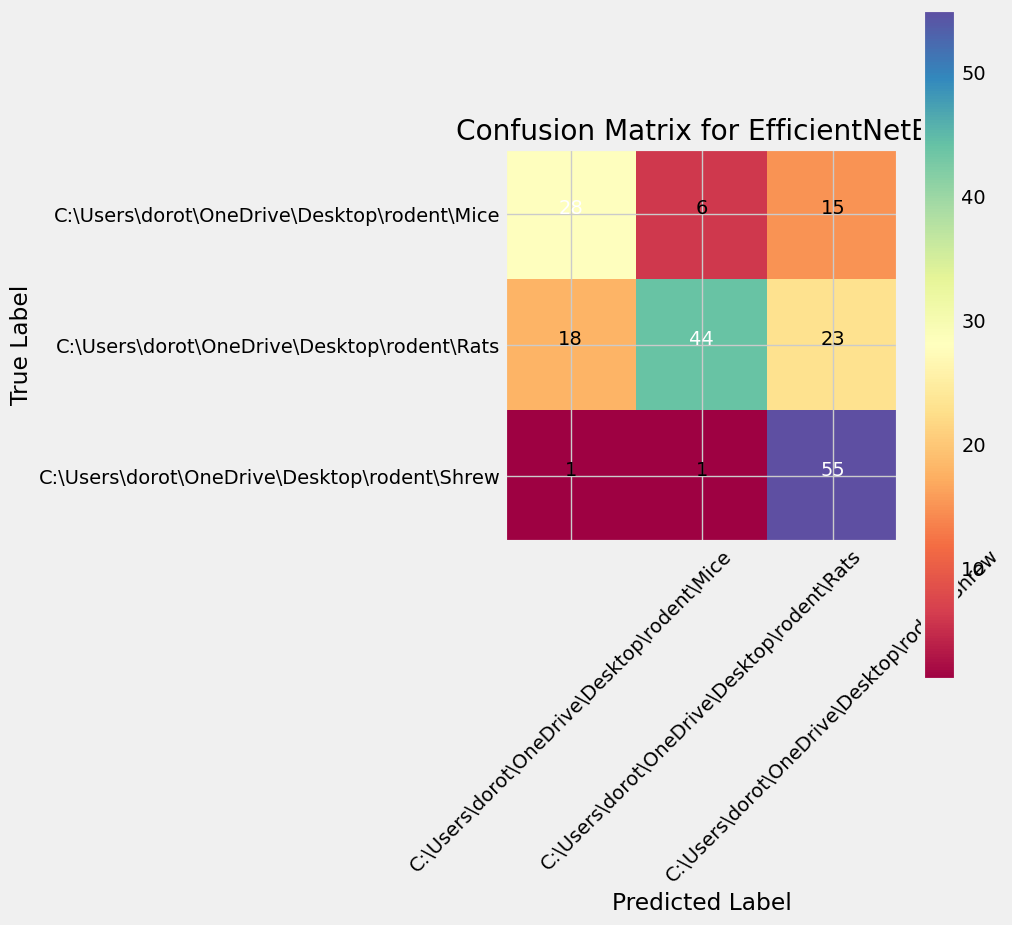

In [52]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, Eff_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Spectral)
plt.title('Confusion Matrix for EfficientNetB0')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [58]:
model.save('Eff_B0.keras')

In [60]:
!pip install fastapi uvicorn pyngrok pillow

  Using cached fastapi-0.115.6-py3-none-any.whl.metadata (27 kB)


In [62]:
Eff_model = tf.keras.models.load_model('Eff_B0.keras')

def preprocess(image: Image.Image):
    # Resize the image to 224x224 (expected input size for MobileNetV2)
    image = image.resize((224, 224))
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Add a batch dimension and preprocess the image
    image_array = np.expand_dims(image_array, axis=0)
    return preprocess_input(image_array)

In [66]:
pip install python-multipart

Note: you may need to restart the kernel to use updated packages.


In [84]:
pip install ngrok

   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ------------- -------------------------- 1.0/3.0 MB 16.7 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 10.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [88]:
# from pyngrok import ngrok
!ngrok authtoken '2qGeYVDRSnKzBc4jXom1xfL25op_h9i9gkx8TriZNgHt6U3q'

Authtoken saved to configuration file: C:\Users\dorot\AppData\Local/ngrok/ngrok.yml


In [92]:
!ngrok config add-authtoken 2qGeYVDRSnKzBc4jXom1xfL25op_h9i9gkx8TriZNgHt6U3q

Authtoken saved to configuration file: C:\Users\dorot\AppData\Local/ngrok/ngrok.yml


In [96]:
from pyngrok import ngrok
import uvicorn
import threading

# Function to run the FastAPI app
def run_app():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Open an ngrok tunnel
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Run the FastAPI app in a separate thread
thread = threading.Thread(target=run_app)
thread.start()


Public URL: NgrokTunnel: "https://9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app" -> "http://localhost:8000"


In [ ]:
import flask
# import joblib
import numpy as np
from flask import request, jsonify
from threading import Thread
from pyngrok import ngrok

app = flask.Flask(__name__)

# # Load a pre-trained scikit-learn model
# model = joblib.load('iris_classifier.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    """Receive features and return model prediction"""
    data = request.get_json(force=True)
    features = np.array(data['features']).reshape(1, -1)
    prediction = Eff_model.predict(features)[0]
    return jsonify({
        'prediction': str(prediction),
        'probabilities': Eff_model.predict_proba(features).tolist()
    })

def start_ngrok():
    """Start ngrok tunnel"""
    public_url = ngrok.connect(
        port=8000, 
        authtoken='2qGeYVDRSnKzBc4jXom1xfL25op_h9i9gkx8TriZNgHt6U3q',
        bind_tls=True
    )
    print(f"Public URL: {public_url}")

if __name__ == '__main__':
    # Start ngrok tunnel in a separate thread
    ngrok_thread = Thread(target=start_ngrok)
    ngrok_thread.start()

    # Run Flask app
    app.run(port=8000)

In [105]:
import requests

url = "http://9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app.ngrok.io/detect/"
files = {'file': open(r"C:\Users\dorot\OneDrive\Desktop\Shrew.png", 'rb')}

response = requests.post(url, files=files)
print(response.json())


SSLError: HTTPSConnectionPool(host='9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app.ngrok.io', port=443): Max retries exceeded with url: /detect/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for '9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app.ngrok.io'. (_ssl.c:1000)")))

In [107]:
import requests
response = requests.get('https://9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app.ngrok.io/detect/', verify=False)
print(response.text)

SSLError: HTTPSConnectionPool(host='9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app.ngrok.io', port=443): Max retries exceeded with url: /detect/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))

In [115]:
pip install openssl

ERROR: Could not find a version that satisfies the requirement openssl (from versions: none)
ERROR: No matching distribution found for openssl


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement openssl (from versions: none)
ERROR: No matching distribution found for openssl


In [117]:
openssl s_client -connect '9ddb-2a0e-1d47-c504-7500-cf9-aa31-eac4-9b51.ngrok-free.app.ngrok.io:443'

SyntaxError: invalid syntax (785607831.py, line 1)

In [119]:
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
async def root():
    return {"message": "Hello, world!"}

In [123]:
!uvicorn app:app

ERROR:    Error loading ASGI app. Attribute "app" not found in module "app".


In [127]:
from flask import Flask
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')


In [131]:
@app.route('/predict', methods=['POST'])
async def classify_image(file: UploadFile = File(...)):
    try:
        # Read the uploaded image
        image_bytes = await file.read()
        image = Image.open(io.BytesIO(image_bytes))

        # Preprocess the image for TensorFlow model
        input_tensor = preprocess(image)

        # Perform inference
        predictions = model.predict(input_tensor)

        # Decode predictions into human-readable labels
        decoded_predictions = tf.keras.applications.efficientnet.decode_predictions(predictions
                                                                                    , top=1)[0]  # Top-1 prediction
        label = decoded_predictions[0][1]  # Class label
        confidence = float(decoded_predictions[0][2])  # Confidence score

        return JSONResponse(content={"label": label, "confidence": confidence})
    except Exception as e:
        return JSONResponse(content={"error": str(e)}, status_code=500)


if __name__ == '__main__':
    app.run(debug=True)

AssertionError: View function mapping is overwriting an existing endpoint function: classify_image

In [137]:
cd C:\Users\dorot\anaconda3\Lib\site-packages\tensorflow\python\platform

C:\Users\dorot\anaconda3\Lib\site-packages\tensorflow\python\platform


In [143]:
pip install setuptools

In [147]:
!python app.py

2024-12-16 17:43:33.568102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Traceback (most recent call last):
  File "C:\Users\dorot\anaconda3\Lib\site-packages\tensorflow\python\platform\app.py", line 21, in <module>
    from tensorflow.python.platform import flags
  File "C:\Users\dorot\anaconda3\Lib\site-packages\tensorflow\__init__.py", line 30, in <module>
    import distutils as _distutils
ModuleNotFoundError: No module named 'distutils'


In [101]:
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
import io

app = FastAPI()

@app.post("/classify/")
async def classify_image(file: UploadFile = File(...)):
    try:
        # Read the uploaded image
        image_bytes = await file.read()
        image = Image.open(io.BytesIO(image_bytes))

        # Preprocess the image for TensorFlow model
        input_tensor = preprocess(image)

        # Perform inference
        predictions = model.predict(input_tensor)

        # Decode predictions into human-readable labels
        decoded_predictions = tf.keras.applications.efficientnet.decode_predictions(predictions
                                                                                    , top=1)[0]  # Top-1 prediction
        label = decoded_predictions[0][1]  # Class label
        confidence = float(decoded_predictions[0][2])  # Confidence score

        return JSONResponse(content={"label": label, "confidence": confidence})
    except Exception as e:
        return JSONResponse(content={"error": str(e)}, status_code=500)


**EfficientNet B1**

In [17]:
from tensorflow.keras.applications import EfficientNetB1

base_model = EfficientNetB1(include_top=False,
                            weights='imagenet',
                            input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable=True

# Add custom layers on top of EfficientNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
y=Dense(3,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=y)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

In [18]:
for layer in base_model.layers:
    layer.trainable = True


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(3, activation="softmax")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [19]:
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy" , metrics  = ["accuracy"])

# Fitting model

History = model.fit(train_gen, epochs= 15, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 137s 177ms/step - accuracy: 0.5625 - loss: 0.9344 - val_accuracy: 0.6958 - val_loss: 1.0294
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.7325 - loss: 0.6136 - val_accuracy: 0.6958 - val_loss: 0.7867
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8363 - loss: 0.4163 - val_accuracy: 0.7483 - val_loss: 0.9110
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.8389 - loss: 0.4330 - val_accuracy: 0.6608 - val_loss: 1.0377
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8672 - loss: 0.3827 - val_accuracy: 0.6364 - val_loss: 1.2106
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.9006 - loss: 0.2718 - val_accuracy: 0.7308 - val_loss: 1.0622
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.8937 - loss: 0.2744 - val_accuracy: 0.7657 - val_loss: 0.7205
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9329 - loss: 0.1948 

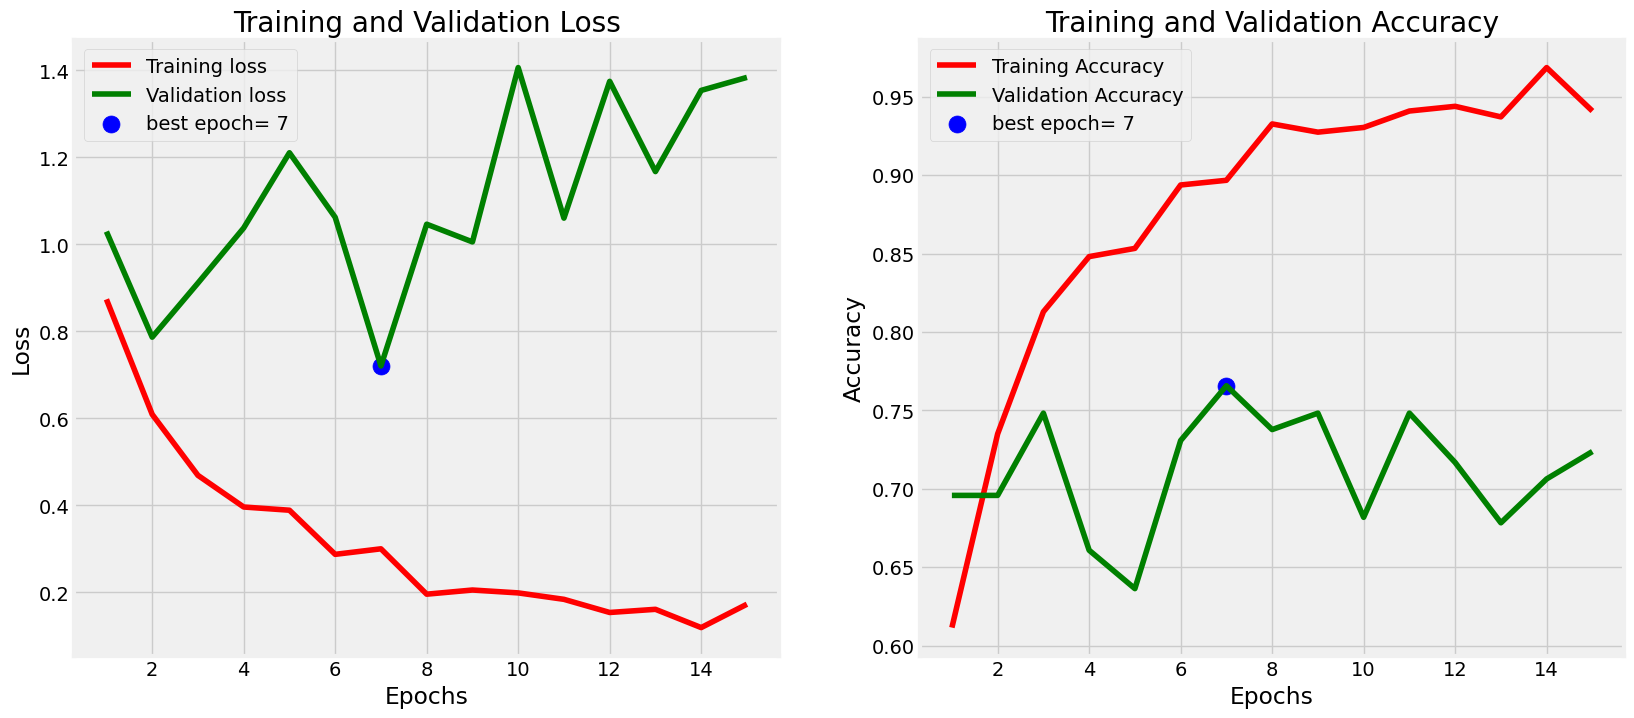

In [20]:
# Define needed variables
tr_acc = History.history['accuracy']
tr_loss = History.history['loss']
val_acc = History.history['val_accuracy']
val_loss = History.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
Eff_preds = model.predict(test_gen)
Eff_pred = np.argmax(Eff_preds, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step


In [22]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, Eff_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9620 - loss: 0.1429
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7401 - loss: 1.3016
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.7305 - loss: 1.4582
Train Loss:  0.1187555342912674
Train Accuracy:  0.9618263244628906
--------------------
Validation Loss:  1.3838696479797363
Validation Accuracy:  0.7237762212753296
--------------------
Test Loss:  1.2274295091629028
Test Accuracy:  0.7351916432380676
              precision    recall  f1-score   support

           0       0.74      0.39      0.51        74
           1       0.79      0.80      0.80       133
           2       0.67      0.94      0.78        80

    accuracy                           0.74       287
   macro avg       0.73      0.71      0.70       287
weighted avg       0.74      0.74      0.72       287



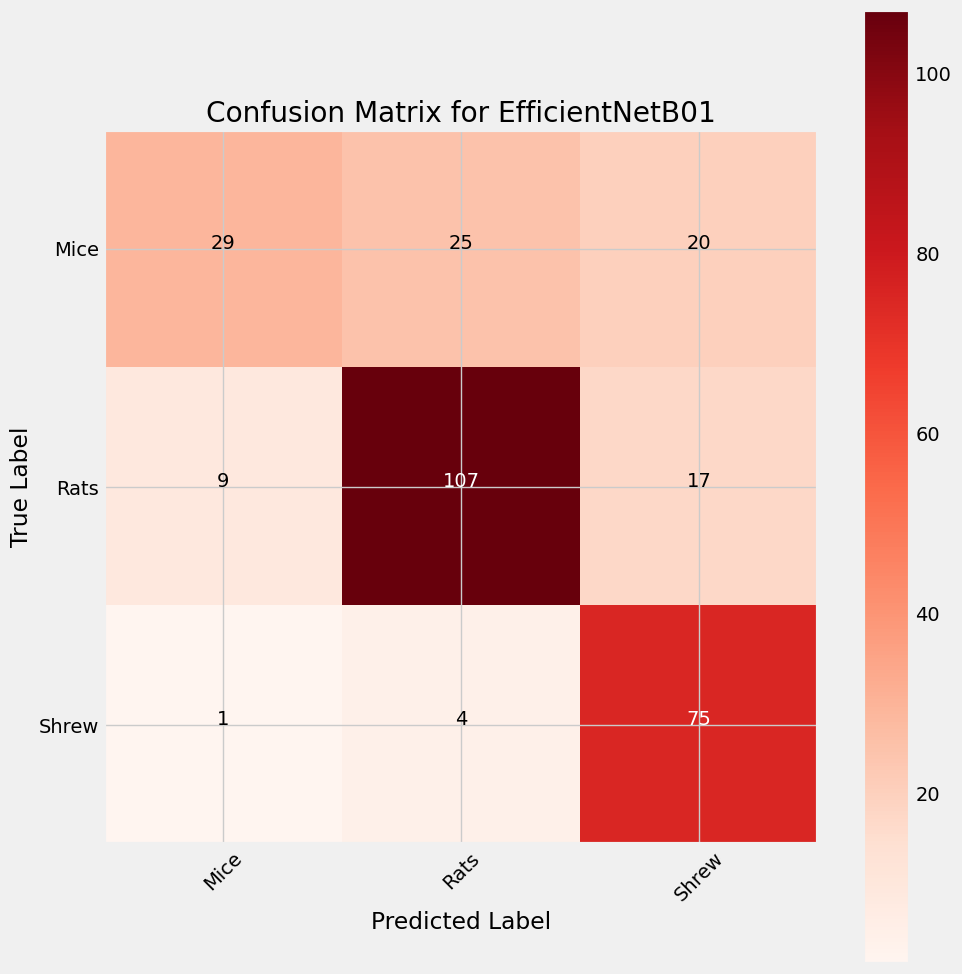

In [23]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, Eff_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix for EfficientNetB01')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


**EfficientNet B7**

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

base_model = EfficientNetB7(include_top=False,
                            weights='/kaggle/input/efficientnet-v7/tensorflow2/default/1/efficientnetb7_notop.h5',
                            input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable=True

# Add custom layers on top of EfficientNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
y=Dense(3,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=y)

In [ ]:
model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = True


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(3, activation="softmax")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy" , metrics  = ["accuracy"])

# Fitting model

History = model.fit(train_gen, epochs= 13, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2805s 16s/step - accuracy: 0.5136 - loss: 1.1381 - val_accuracy: 0.6434 - val_loss: 0.9557
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2642s 16s/step - accuracy: 0.6658 - loss: 0.7598 - val_accuracy: 0.6224 - val_loss: 0.7967
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2598s 16s/step - accuracy: 0.7358 - loss: 0.6392 - val_accuracy: 0.6294 - val_loss: 0.7964
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2631s 16s/step - accuracy: 0.7911 - loss: 0.5336 - val_accuracy: 0.6993 - val_loss: 0.9992
Epoch 5/10
127/167 ━━━━━━━━━━━━━━━━━━━━ 10:02 15s/step - accuracy: 0.8337 - loss: 0.4339

In [ ]:
# Define needed variables
tr_acc = History.history['accuracy']
tr_loss = History.history['loss']
val_acc = History.history['val_accuracy']
val_loss = History.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
Eff_preds = model.predict(test_gen)
Eff_pred = np.argmax(Eff_preds, axis=1)

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print(classification_report(test_gen.classes, Eff_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, Eff_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for EfficientNetv7')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
cm

In [ ]:
from keras.models import load_model

model.save('EfficientNet_B07.h5')

In [ ]:
pip install google
from google.colab import drive
drive.mount('/content/drive')

# Save the file to Drive
!cp /path/to/model.h5 /content/drive/MyDrive/model.h5

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def Image_classes_prediction(path, model):
    img = load_img(path, target_size = (224, 224))
    in_arr = img_to_array(img)
    in_arr = preprocess_input(in_arr)
    plt.imshow(in_arr)
    in_arr = np.expand_dims(in_arr, axis = 0)

    Pred = model.predict(in_arr)
    Pred_ = np.argmax(Pred)

    if Pred_ == 0:
        print('Rat')
    elif Pred_ == 1:
        print('Mouse')
    else:
        print('Shrew')

    return Pred_

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Shrew


2

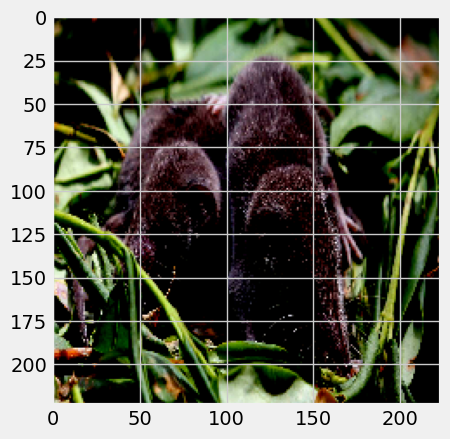

In [25]:
path = '/content/1024px-Crocidura_HC2.jpg'
Image_classes_prediction(path, model)
